# Regulatory region extractor
Here I'll prototype a script to pull putative regulatory regions out of a set of genomic scaffolds using a `gff` file. I'll use a number of functions from `gffutils`, which is currently being integrated into `biopython`.

In [1]:
# Core
import re, glob, sys, string
import pandas as pd
from pathlib import Path
import numpy as np
# Plotting
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import colors as mcolors
import matplotlib.cm as cm
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm.notebook import tqdm
# Bio
from Bio import SeqIO
from Bio.Seq import Seq
import gffutils

In [2]:
update_results = Path("../../../GitHub_repos/finalproject/scratch/Pamilis_funannotate/TRAIN/Portulaca-amilis.v0-FA1.6.0/update_results/")

The function above will create an sqlite3 database at `GitHub_repos/finalproject/scratch/Pamilis_funannotate/TRAIN/Portulaca-amilis.v0-FA1.6.0/update_results/Portulaca_amilis.gff.sql`. However, I've already built this database and done some time consuming steps to edit it (see below), so I'll just load from the SQL file.

In [3]:
# gffdb = gffutils.create_db(data=str(next(update_results.glob("*.gff3"))), dbfn=str(update_results/"Portulaca_amilis.gff.sql"), 
#                            disable_infer_transcripts=True, disable_infer_genes=True,
#                            verbose=True,merge_strategy="create_unique", force=True)

In [5]:
gffdb = gffutils.FeatureDB("/Users/iangilman/Dropbox/GitHub_repos/finalproject/scratch/Pamilis_funannotate/TRAIN/Portulaca-amilis.v0-FA1.6.0/update_results/Portulaca_amilis.gff.sql")

I used`merge_strategy=create_unique` because my `gff` looks like

```bash
##gff-version 3
scaffold_1	funannotate	gene	2215	3431	.	-	.	ID=FUN_000001;
scaffold_1	funannotate	mRNA	2215	3431	.	-	.	ID=FUN_000001-T1;Parent=FUN_000001;product=hypothetical protein;
scaffold_1	funannotate	exon	3267	3431	.	-	.	ID=FUN_000001-T1.exon1;Parent=FUN_000001-T1;
scaffold_1	funannotate	exon	3146	3190	.	-	.	ID=FUN_000001-T1.exon2;Parent=FUN_000001-T1;
scaffold_1	funannotate	exon	2914	3067	.	-	.	ID=FUN_000001-T1.exon3;Parent=FUN_000001-T1;
scaffold_1	funannotate	exon	2736	2841	.	-	.	ID=FUN_000001-T1.exon4;Parent=FUN_000001-T1;
scaffold_1	funannotate	exon	2215	2297	.	-	.	ID=FUN_000001-T1.exon5;Parent=FUN_000001-T1;
scaffold_1	funannotate	CDS	3267	3431	.	-	0	ID=FUN_000001-T1.cds;Parent=FUN_000001-T1;
scaffold_1	funannotate	CDS	3146	3190	.	-	0	ID=FUN_000001-T1.cds;Parent=FUN_000001-T1;
scaffold_1	funannotate	CDS	2914	3067	.	-	0	ID=FUN_000001-T1.cds;Parent=FUN_000001-T1;
scaffold_1	funannotate	CDS	2736	2841	.	-	2	ID=FUN_000001-T1.cds;Parent=FUN_000001-T1;
```

which has duplicate `ID`s, even though they are separated in space.

We can access genes in a `pandas`- or `dict`-like way with keys, and if we pair the database with sequence data we can extract individual features.

In [6]:
scaffolds = Path("../../../GitHub_repos/finalproject/scratch/Pamilis_funannotate/CLEAN/Pamilis_Final_HiRise.clean.sorted.fasta")

In [7]:
gene = gffdb["FUN_000001-T1"]
gene.sequence(fasta=str(scaffolds))

'ATGATCAAAGTAGTCTTGATGGTCTTGGATATGAATCAGAAGCATGTTCTGAAGCTGGTTGACGCTTGGAAGCTAGGTCATGCGCCGATGTTGGTTGGCCTGCTTAGTTTCTTCCGTAAAGCTGGCCGAATTGGTCCACCTCATTTCGCCGAGAGGTGGGTCAAGGTTATGCACTCCATTTCGCCGTGAAGTGCAATATTTGAGTTTTTGTAGGTTGACCTGCTTAGTTTCTGCCGTAAAGCTGGTCGAAGTTGATCCGCTTCATTTCGCCGTGAGACGGATCGAGGTGACGTACTtcatttcgccgtgaagcatgccgtgatgatgatctgatccacttcatttcgccgtgaggtgggtcaaggtgacgcttggaagccaaatcctgcgtctgtgtaagttgaccagcttagtttctgccgtaaagctggtcagagttgatccacttcatttcgccatgaagcatgccgaggtGATGTCGAGTCGGTCCACTTCATTTCGCCGTGAGGTGGATCCAGGTGACGTGCTTCATTTCGCCGTGAAGCATGTTGGGATGATGAGTTGATCCACTTCATTTCGCCGTGAGGTAGATCAAGGTGACGGGCTTCATTTCGCCGTGAAGCGCGGGACCTGTGTTTGTGTGCTGAAAAGGGTGTCATCGTATtgtgagggcccGATGACGGCCGCTGAGGATGAGTACGTCTCGTTGTAAACGCCTGACGACCGACGTATTTTGTTCATGCATGGTCCTGCAAAAAGACAAAGAAAGTATCAGTTTTTtttttaatttTACAAAGGGTTAGGAAATTACCTTTCTGATTGATTGATCTTAACTGGTCGGAAGCGGTGAGAATTTTCGGTTCTCCCGATTTTTGTATTCCATTTTTGTAGGAGAAAACAAAAAAGAGAGAATATATACACAAAAAAGAGAAGGAAAAAAAATTAAAAAAAAATAAAATAAAATAAAATAAATAAAAAATAAAAAGGATGGAGAACCCG

We can also get sub-features of genes using the `.children` method.

In [8]:
for cd in gffdb.children(id='FUN_000001', featuretype="CDS"):
    print(cd)

scaffold_1	funannotate	CDS	3267	3431	.	-	0	ID=FUN_000001-T1.cds;Parent=FUN_000001-T1;
scaffold_1	funannotate	CDS	3146	3190	.	-	0	ID=FUN_000001-T1.cds;Parent=FUN_000001-T1;
scaffold_1	funannotate	CDS	2914	3067	.	-	0	ID=FUN_000001-T1.cds;Parent=FUN_000001-T1;
scaffold_1	funannotate	CDS	2736	2841	.	-	2	ID=FUN_000001-T1.cds;Parent=FUN_000001-T1;
scaffold_1	funannotate	CDS	2215	2297	.	-	1	ID=FUN_000001-T1.cds;Parent=FUN_000001-T1;


The `count_features_of_type` shows how many of each genomic feature are in the `gff`.

In [9]:
for f in gffdb.featuretypes():
    print("{}: {}".format(f, gffdb.count_features_of_type(f)))

CDS: 258581
exon: 267981
five_prime_UTR: 26969
gene: 53094
intron: 208192
mRNA: 58732
tRNA: 1057
three_prime_UTR: 25336
upstream_promoter: 57188


Maybe most useful for us here is the `create_introns` method, which automatically infers introns and can be paired with `update` to create a new feature.

In [10]:
introns = list(gffdb.create_introns())

The update function below is pretty computationally intense, so try to save the database after so that it can be reloaded rather than rerunning the code chunk each time. I've commented out the next few blocks so I don't overwrite my original files.

In [11]:
# gffdb.update(introns, disable_infer_transcripts=True, disable_infer_genes=True,
#     verbose=True, merge_strategy="create_unique");

In [12]:
# with open(update_results/"Portulaca_amilis.all-features.gff3", "w+") as o:
#     o.write("##gff-version 3\n")
#     for g in gffdb.iter_by_parent_childs():
#         for f in g:
#             o.write(str(f)+"\n")

Here are the blocks to write the intron data to files.

In [13]:
# with open(update_results/"Portulaca_amilis.introns.gff3", "w+") as o:
#     o.writelines([str(i)+"\n" for i in introns])

In [14]:
# introndb = gffutils.create_db(data=str(update_results/"Portulaca_amilis.introns.gff3"), 
#                     dbfn=str(update_results/"Portulaca_amilis.introns.sql"), 
#                     disable_infer_transcripts=True, disable_infer_genes=True,
#                     verbose=True,merge_strategy="create_unique")

In [15]:
introndb = gffutils.FeatureDB("/Users/iangilman/Dropbox/GitHub_repos/finalproject/scratch/Pamilis_funannotate/TRAIN/Portulaca-amilis.v0-FA1.6.0/update_results/Portulaca_amilis.introns.sql")

In [16]:
for f in introndb.featuretypes():
    print("{}: {}".format(f, introndb.count_features_of_type(f)))

intron: 208192


Now I'll parse the intron `gff` and create a list of `biopython` sequence records. This just facilitates writing the output `fasta`. One unintuitive thing to note is that sequences **must be added as `Seq` instances** to `SeqRecord`s because `biopython` doesn't like working with strings. I'm not sure why using `sequence='ATGCGT...` isn't enough of a cue to interpret a string as a sequence, alas...

In [17]:
intron_fasta = update_results / "Portulaca_amilis.introns.fasta"

In [18]:
with open(intron_fasta, "w+") as handle:
    
    records = []
    for i in introndb.iter_by_parent_childs(featuretype="intron"):
        intron_id = i[0].id
        scaffold = i[0].seqid
        source = i[0].source
        start = i[0].start
        stop = i[0].stop
        strand = i[0].strand

        intron_info = "{} ({}) {}-{} {}".format(scaffold, strand, start, stop, source)
        seq = Seq(i[0].sequence(fasta=str(scaffolds)))

        records.append(SeqIO.SeqRecord(seq=seq, id=intron_id, description=intron_info))

    SeqIO.write(sequences=records, handle=handle, format="fasta")

The last piece I need to generate is the is set of 2kb windows upstream of the transcript start sites (TSSs). I'll start by looking at the hardest case, a gene with a 5'UTR on the (-) strand.

In [19]:
for f in gffdb.featuretypes():
    for c in gffdb.children(id='FUN_000035', featuretype=f):
        print(c)

scaffold_1	funannotate	CDS	175410	175525	.	-	0	ID=FUN_000035-T1.cds;Parent=FUN_000035-T1;
scaffold_1	funannotate	CDS	175122	175281	.	-	1	ID=FUN_000035-T1.cds;Parent=FUN_000035-T1;
scaffold_1	funannotate	CDS	173226	173287	.	-	0	ID=FUN_000035-T1.cds;Parent=FUN_000035-T1;
scaffold_1	funannotate	CDS	172658	172814	.	-	1	ID=FUN_000035-T1.cds;Parent=FUN_000035-T1;
scaffold_1	funannotate	CDS	172238	172515	.	-	0	ID=FUN_000035-T1.cds;Parent=FUN_000035-T1;
scaffold_1	funannotate	CDS	171479	171605	.	-	1	ID=FUN_000035-T1.cds;Parent=FUN_000035-T1;
scaffold_1	funannotate	exon	175410	175847	.	-	.	ID=FUN_000035-T1.exon1;Parent=FUN_000035-T1;
scaffold_1	funannotate	exon	175122	175281	.	-	.	ID=FUN_000035-T1.exon2;Parent=FUN_000035-T1;
scaffold_1	funannotate	exon	173226	173287	.	-	.	ID=FUN_000035-T1.exon3;Parent=FUN_000035-T1;
scaffold_1	funannotate	exon	172658	172814	.	-	.	ID=FUN_000035-T1.exon4;Parent=FUN_000035-T1;
scaffold_1	funannotate	exon	172238	172515	.	-	.	ID=FUN_000035-T1.exon5;Parent=FUN_000035

I'll make a little plot of this gene so show how it's organized.

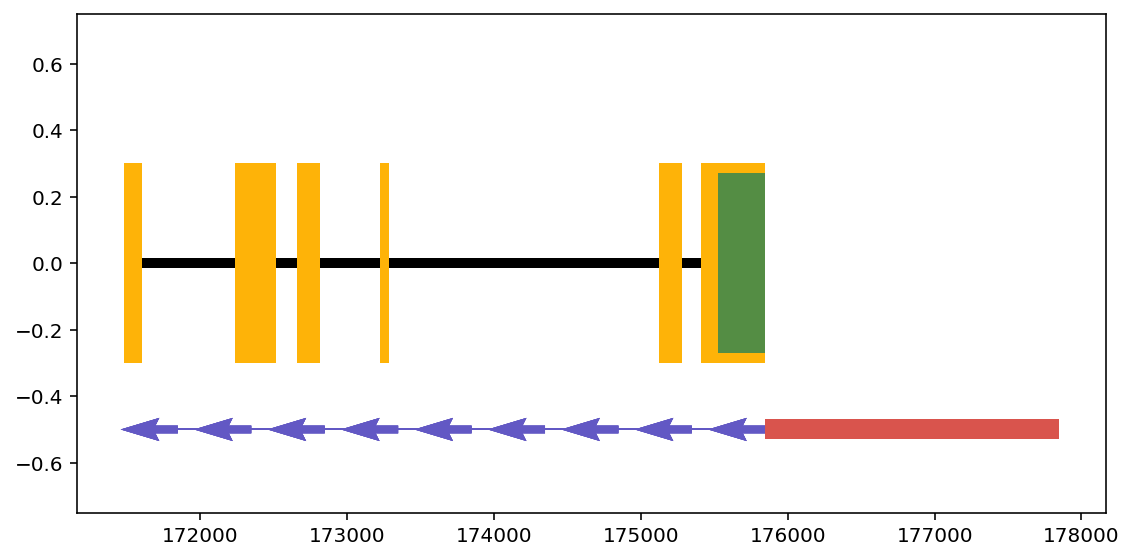

In [20]:
fig, ax = plt.subplots(figsize=(8,4))

gene = gffdb["FUN_000035"]

ax.hlines(y=0, xmin=gene.start, xmax=gene.stop, linewidth=5, color="black")

for f in ["mRNA", "exon", "three_prime_UTR", "five_prime_UTR"]:
    if f=="mRNA":
        y=-0.5
        color="xkcd:iris"
        linewidth=1
    elif f=="exon":
        y=0
        color="xkcd:amber"
        linewidth=100
    elif f=="three_prime_UTR":
        y=0
        color="xkcd:denim blue"
        linewidth=90
    elif f=="five_prime_UTR":
        y=0
        color="xkcd:fern green"
        linewidth=90
    for c in gffdb.children(id='FUN_000035', featuretype=f):
        ax.hlines(y=y, xmin=c.start, xmax=c.stop, linewidth=linewidth, color=color)
    
    if gene.strand=="-":
        x=gene.stop
        upstream_region = x+2000
        ax.quiver(np.arange(gene.stop, gene.start, -500), 
              np.repeat(-0.5, len(np.arange(gene.stop, gene.start, -500))), 
                        -1, 0, color="xkcd:iris")
    elif gene.strand=="+":
        x=gene.start
        upstream_region = x-2000
        ax.quiver(np.arange(gene.stop, gene.start, -500), 
                  np.repeat(-0.5, len(np.arange(gene.start, gene.stop, 500))), 
                            1, 0, color="xkcd:iris")
    ax.hlines(y=-0.5, xmin=x, xmax=upstream_region, color="xkcd:pale red", linewidth=10)
ax.set_ylim(-0.75, 0.75)
plt.tight_layout()

So we can see that the 5'UTR region is *inside* of the first exon, so it might be easier to base our TSS on the mRNA position. I'm going to try a bit of a brute force method that creates new lines from existing mRNA lines. After spending some time reading [the docs](http://daler.github.io/gffutils/index.html), I can't figure out the right tool to use to automatically generate new feature IDs, and I'm worried about messing up existing relations within the database.

In [21]:
promoter_strings = []

i=0
for mrna in gffdb.all_features(featuretype="mRNA"):
    mrna_string = str(mrna)
    
    if mrna.strand=="+":
        TSS = mrna.start-1
        promoter_string = re.sub("\tmRNA\t[\d]+\t[\d]+", 
                                 "\t2kb_promoter\t{}\t{}".format(TSS-2000, TSS), 
                                 mrna_string)
    elif mrna.strand=="-":
        TSS = mrna.stop+1
        promoter_string = re.sub("\tmRNA\t[\d]+\t[\d]+", 
                                 "\t2kb_promoter\t{}\t{}".format(TSS, TSS+2000), 
                                 mrna_string)
    else:
        print(mrna_string)
    
    print(mrna_string)
    print(promoter_string)
    
    i+=1
    if i>10:break

scaffold_1	funannotate	mRNA	2215	3431	.	-	.	ID=FUN_000001-T1;Parent=FUN_000001;product=hypothetical protein;
scaffold_1	funannotate	2kb_promoter	3432	5432	.	-	.	ID=FUN_000001-T1;Parent=FUN_000001;product=hypothetical protein;
scaffold_1	funannotate	mRNA	4075	5661	.	-	.	ID=FUN_000002-T1;Parent=FUN_000002;product=hypothetical protein;
scaffold_1	funannotate	2kb_promoter	5662	7662	.	-	.	ID=FUN_000002-T1;Parent=FUN_000002;product=hypothetical protein;
scaffold_1	funannotate	mRNA	6298	7208	.	-	.	ID=FUN_000003-T1;Parent=FUN_000003;product=hypothetical protein;
scaffold_1	funannotate	2kb_promoter	7209	9209	.	-	.	ID=FUN_000003-T1;Parent=FUN_000003;product=hypothetical protein;
scaffold_1	funannotate	mRNA	7459	9400	.	+	.	ID=FUN_000004-T1;Parent=FUN_000004;product=hypothetical protein;
scaffold_1	funannotate	2kb_promoter	5458	7458	.	+	.	ID=FUN_000004-T1;Parent=FUN_000004;product=hypothetical protein;
scaffold_1	funannotate	mRNA	13154	13842	.	-	.	ID=FUN_000005-T1;Parent=FUN_000005;product=hypothe

The associated `.tbl` file lists the lengths of each scaffold and can be used to determine if promoter regions extend past scaffold boundaries. To be safe, I'll drop any regions that extend past scaffold boundaries. This is because when doing a preliminary scan of the `gff` and `tbl` files it looks like most cases where this happens are very small scaffolds that are not part of the primary assembly.

In [22]:
tblpath = next(update_results.glob("*.tbl"))

In [23]:
scaffold_dict = {}

with open(tblpath, "r") as f:
    for line in f:
        if line.startswith(">"):
            scaffold = line.split()[-1]
            coords = [eval(i) for i in next(f).split("\t")[:2]]
            scaffold_dict[scaffold] = coords

Let's try this again and check where promoters extend past scaffold boundaries.

In [25]:
promoter_strings = []
extended_past_scaffold = 0
for mrna in gffdb.all_features(featuretype="mRNA"):
    mrna_string = str(mrna)
    scaffold = mrna_string.split("\t")[0]
    scaffold_end = scaffold_dict[scaffold][1]
    
    if mrna.strand=="+":
        TSS = mrna.start-1
        promoter_start = TSS-2000
        promoter_string = re.sub("\tmRNA\t[\d]+\t[\d]+", 
                                 "\tupstream_promoter\t{}\t{}".format(promoter_start, TSS), 
                                 mrna_string)+"\n"
    elif mrna.strand=="-":
        TSS = mrna.stop+1
        promoter_start = TSS+2000
        promoter_string = re.sub("\tmRNA\t[\d]+\t[\d]+", 
                                 "\tupstream_promoter\t{}\t{}".format(TSS, promoter_start), 
                                 mrna_string)+"\n"
    else:
        print("ERROR IN\n{}".format(mrna_string))
    
    if (promoter_start<1) or (promoter_start>scaffold_end):
#         print("FEATURE EXTENDS PAST SCAFFOLD\n{}\n".format(mrna_string))
        extended_past_scaffold += 1
        continue
    
    promoter_string = re.sub("product=hypothetical protein", "hypothetical promoter region", promoter_string)
    promoter_strings.append(promoter_string)

print("{} features extended past scaffold".format(extended_past_scaffold))

1544 features extended past scaffold


The majority of features that extended past the scaffold occured in the tiny scaffolds that we aren't as concerned with. Now I can write these to a `gff`. It's a little annoying that the `gffutils` package doesn't have more writing capabilities.

In [26]:
with open(update_results/"Portulaca_amilis.hypothetical_promoters.gff3", "w+") as o:
    o.write("##gff-version 3\n")
    o.writelines(promoter_strings)

Now to create a database and a `fasta` file of promoter sequencers.

In [376]:
promoterdb = gffutils.create_db(data=str(update_results/"Portulaca_amilis.hypothetical_promoters.gff3"), 
                    dbfn=str(update_results/"Portulaca_amilis.hypothetical_promoters.sql"), 
                    disable_infer_transcripts=True, disable_infer_genes=True,
                    verbose=True,merge_strategy="create_unique")

2020-07-17 16:10:10,634 - INFO - Populating features
2020-07-17 16:10:15,310 - INFO - Populating features table and first-order relations: 57187 features
2020-07-17 16:10:15,311 - INFO - Updating relations
2020-07-17 16:10:15,684 - INFO - Creating relations(parent) index
2020-07-17 16:10:15,703 - INFO - Creating relations(child) index
2020-07-17 16:10:15,729 - INFO - Creating features(featuretype) index
2020-07-17 16:10:15,752 - INFO - Creating features (seqid, start, end) index
2020-07-17 16:10:15,779 - INFO - Creating features (seqid, start, end, strand) index
2020-07-17 16:10:15,811 - INFO - Running ANALYZE features


In [27]:
promoterdb = gffutils.FeatureDB("/Users/iangilman/Dropbox/GitHub_repos/finalproject/scratch/Pamilis_funannotate/TRAIN/Portulaca-amilis.v0-FA1.6.0/update_results/Portulaca_amilis.hypothetical_promoters.sql")

In [28]:
for f in promoterdb.featuretypes():
    print("{}: {}".format(f, promoterdb.count_features_of_type(f)))

upstream_promoter: 57188


Add the promoter features to the large database.

In [29]:
# gffdb.update(list(promoterdb.all_features()), disable_infer_transcripts=True, disable_infer_genes=True,
#     verbose=True, merge_strategy="create_unique")

In [ ]:
def featuredb_to_fasta(db, featuretype, ref_fasta, out_fasta, MEME=False):
    '''Creates a fasta of the sequences of a particular feature type from a
    gffuntils FeatureDB database. Fasta header will be constructed as
    
    >ID SEQID (STRAND) START-STOP SOURCE
    
    For example, the gff line
    
    "scaffold_1	gffutils_derived	intron	2298	2735	.	-	.	ID=FUN_000001-T1.exon4,FUN_000001-T1.exon5;Parent=FUN_000001-T1;"
    
    will read
    
    ">FUN_000001-T1.exon4 scaffold_1 (-) 2298-2735 gffutils_derived"
    
    Parameters
    ----------
    db : <gffutils.interface.FeatureDB> gffutils FeatureDB
    featuretype : <str> Feature type to extract from db
    ref_fasta : <str> Path to reference fasta for extracting sequences
    out_fasta : <str> Path to output fasta file. Will overwrite by default
    MEME : <bool> Whether or not to write MEME compatible fasta headers
    Returns
    -------
    N/A
    '''
    
    
    with open(out_fasta, "w+") as handle:    
        records = []
        for i in db.iter_by_parent_childs(featuretype=featuretype):
            feature_id = i[0].id
            scaffold = i[0].seqid
            source = i[0].source
            start = i[0].start
            stop = i[0].stop
            strand = i[0].strand

            feature_info = "{} ({}) {}-{} {}".format(scaffold, strand, start, stop, source)
            seq = Seq(i[0].sequence(fasta=str(ref_fasta)))
            
            meme_feature_info = "ID={};Strand=({});Source={}".format(feature_id, strand, source)
            meme_id = "{}:{}-{}".format(scaffold, start, stop)
            
            if MEME:
                records.append(SeqIO.SeqRecord(seq=seq, id=fimo_id, description=meme_feature_info))
            else:
                records.append(SeqIO.SeqRecord(seq=seq, id=feature_id, description=feature_info))

        SeqIO.write(sequences=records, handle=handle, format="fasta")

Now loop over the feature types. Remember to set `MEME=True` so that MEME programs refer to element positions _in the genome_ rather than _relative to element_.

In [32]:
for feature in ["three_prime_UTR", "upstream_promoter", "intron", "upstream_promotor", "five_prime_UTR"]:
    path = update_results / "Portulaca_amilis.{}.MEME.fasta".format(feature)
    featuredb_to_fasta(db=gffdb, featuretype=feature, ref_fasta=scaffolds, out_fasta=path, MEME=True)